In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import t
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from IPython.display import display
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

## Question 1

In [2]:
data_california = datasets.fetch_california_housing()
dataset_cal = data_california['data']
target_cal = data_california['target']

In [3]:
target_cal

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [4]:
# standardizing all the data and target
mean_data = dataset_cal.mean(axis=0)
std_data = dataset_cal.std(axis=0)

mean_target = target_cal.mean(axis=0)
std_target = target_cal.std(axis=0)

In [5]:
dataset_cal_scaled = (dataset_cal - mean_data)/std_data
target_cal_scaled = (target_cal - mean_target)/std_target

In [6]:
n = dataset_cal.shape[0]

In [8]:
# calculate the theta with the normal equation
X = np.concatenate((np.ones((n,1)), dataset_cal_scaled), axis=1)
y = target_cal_scaled
theta_vector = np.linalg.pinv(X.T @ X) @ X.T @ y
theta_vector

array([-7.20951077e-15,  7.18952272e-01,  1.02910780e-01, -2.30106933e-01,
        2.64917894e-01, -3.90232364e-03, -3.40803413e-02, -7.79845446e-01,
       -7.54415222e-01])

In [9]:
y_hat = X @ theta_vector
y_hat_original_scale = y_hat * std_target + mean_target
mse_mine = 1/n * np.sum((y_hat - y)**2)
R2_mine = 1 - np.sum((y-y_hat)**2)/np.sum((y-y.mean())**2)

In [10]:
mse_mine, R2_mine

(0.3937673148001949, 0.6062326851998051)

In [12]:
# using sklean to solve the problem
model_cal_sklearn = LinearRegression()
model_cal_sklearn.fit(X, y)
y_hat_sklearn = model_cal_sklearn.predict(X)
mse_sklearn = 1/n * np.sum((y_hat_sklearn - y)**2)
R2_sklearn = 1 - np.sum((y-y_hat_sklearn)**2)/np.sum((y-y.mean())**2)

In [13]:
mse_sklearn, R2_sklearn

(0.3937673148001949, 0.6062326851998051)

Therefore it is the same with sklean.

In [14]:
alpha = 0.01
p = 8
dof = n - p -1
t99 = t.ppf(1-alpha, df = dof)
sigma_hat2 = 1/(n-p-1)*np.sum((y-y_hat)**2)
for j in range(p+1):
    theta_j_hat = theta_vector[j]
    interval_j = (theta_j_hat - t99*np.sqrt(sigma_hat2)*np.sqrt(np.linalg.pinv(X.T@X)[j,j]), theta_j_hat + t99*np.sqrt(sigma_hat2)*np.sqrt(np.linalg.pinv(X.T@X)[j,j]))
    print(f"For {j+1}-th coefficient, the interval is [{interval_j[0]}, {interval_j[1]}]")
    

For 1-th coefficient, the interval is [-0.010164080484893465, 0.010164080484879046]
For 2-th coefficient, the interval is [0.702877289660945, 0.7350272547899199]
For 3-th coefficient, the interval is [0.09158681658642585, 0.11423474284206699]
For 4-th coefficient, the interval is [-0.2594647413961249, -0.20074912386291976]
For 5-th coefficient, the interval is [0.23803588078804444, 0.29179990749360935]
For 6-th coefficient, the interval is [-0.0147456640668595, 0.006941016781450658]
For 7-th coefficient, the interval is [-0.04428663924788494, -0.02387404326324998]
For 8-th coefficient, the interval is [-0.8108377659811777, -0.7488531251210025]
For 9-th coefficient, the interval is [-0.7848434702194468, -0.7239869739744981]


## Question 2

In [15]:
# read the csv file
with open('data.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
data_array = np.array(data,dtype=float)
data_array.shape

(442, 211)

In [16]:
# we here set the X and also y
dataSet = data_array[:, :-1]
targetSet = data_array[:,-1]

In [17]:
np.random.seed(0) # set the seed to 0
X_train, X_test, y_train, y_test = train_test_split(dataSet, targetSet, test_size=0.25)

In [18]:
# standardize our X data, both for train and test set
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [19]:
model2 = LinearRegression()
model2.fit(X_train_std, y_train)

LinearRegression()

In [20]:
n2 = data_array.shape[0] # total number of data, including train and test
p2 = data_array.shape[1] # total number of features
y_hat = model2.predict(X_test_std)
mse2 = 1/y_hat.shape[0] * (np.sum((y_test - y_hat)**2))
r2_2 = 1 - np.sum((y_test-y_hat)**2)/np.sum((y_test-y_test.mean())**2)
mse2, r2_2

(3597.3621584310013, 0.2753701753601172)

## Question 3

In [23]:
def selectCoeff(X, y, S):
    """
    we suppose what we input is already standardized
    S is the set that contained the features already selected, that is to say we need to avoid it
    """ 
    n = X.shape[0]
    p = X.shape[1]
    theta_list = [] # a list to save all the theta values
    p_list = [] # a list to save all the p values
    for j in range(p):
        if j not in S:
            # loop for every single feature that we can choose from, i.e. that is not from set S

            ## if we add a column of one
            X_j = np.concatenate((np.ones((n,1)), X[:,j].reshape((n,1))), axis=1)
            theta_vector = np.linalg.pinv(X_j.T @ X_j) @ X_j.T @ y # according to normal equation
            theta_j = theta_vector[-1]
#             print(f"if we add a column of one, theta shape:{theta_vector.shape}")
            y_hat = X_j @ theta_vector

            ## if we don't add a column of one
#             X_j = X[:,1]
#             theta_vector = np.linalg.pinv(X.T @ X) @ X.T @ y
#             theta_j = theta_vector[-1]
#             print(f"if we don't add a column of one, theta shape:{theta_vector.shape}")
#             y_hat = X @ theta_vector

            theta_list.append(theta_j)

            # calculate the statistique of the test
            sigma_hat2 = 1/(n-p-1)*np.sum((y-y_hat)**2)
            T_j = theta_j/(np.sqrt(sigma_hat2) * np.sqrt(np.linalg.pinv(X.T@X)[j,j]))
            p_value = 2 * (1 - t.cdf(T_j, df=n-1-1))
            p_list.append(p_value)
        else: # if j in S
            p_list.append(0.99) # just to take a place
    j = np.argmin(p_list)
    return j, p_list

**Significance of p-value:**

In the tests of no effects we conduct in the loop, the p-value quantifies the strength of evidence against the null hypothesis, which is the hypothesis that the j-th feature is of no effect to the model. The smaller p-value is, the stronger link of the target value with the j-th feature. That is to say, the feature with the smallest p-value from the no effect test is the most correlated feature with the target result.

iter 0
p_min:2.0401702549577294e-10
iter 1
p_min:1.3570393697648342e-09
iter 2
p_min:3.4587379893480374e-07
iter 3
p_min:1.0427860743345008e-05
iter 4
p_min:2.180427771092397e-05
iter 5
p_min:2.8231274803225404e-05
iter 6
p_min:1.1569391077825841e-05
iter 7
p_min:0.0014302904667593541
iter 8
p_min:0.0008986787110794037
iter 9
p_min:0.0025959261673478284
iter 10
p_min:0.0012788764125510887
iter 11
p_min:0.002816862640669271
iter 12
p_min:0.002215614176020342
iter 13
p_min:0.002672228808960675
iter 14
p_min:0.010339412736292575
iter 15
p_min:0.013509197292853603
iter 16
p_min:0.02032413888409712
iter 17
p_min:0.04931698930521056
iter 18
p_min:0.08014459229578663


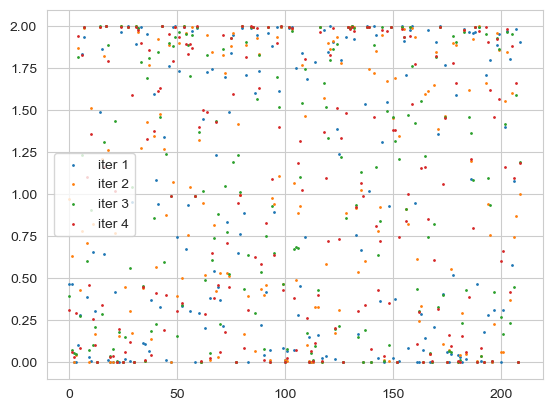

In [24]:
X = X_train_std.copy() # use standardized data
y = y_train.copy()
S = set()
p_min = -1
n_iter = 0
plt.figure()
while p_min <= 0.05: # stop adding features to the set S when exceed
    print(f"iter {n_iter}")
    j, p_list = selectCoeff(X_train_std, y, S) # get the feature with the smallest p-value
    S.add(j) # add j to the set, that is also deleting j from X
    X_j = np.concatenate((np.ones((X.shape[0],1)), X[:,j].reshape((X.shape[0],1))), axis=1)
    theta_vector = np.linalg.pinv(X_j.T @ X_j) @ X_j.T @ y
    y_hat = X_j @ theta_vector # predict the result with the j-th feature
    y = y - y_hat # subtract from y the predictions of the model with the feature j
    p_min = p_list[j] # condition for the next loop
    n_iter = n_iter+1
    if n_iter < 5: # for the first 5 iterations
        plt.scatter([k for k in range(X.shape[1])], p_list, s=1, label=f"iter {n_iter}")
    print(f"p_min:{p_min}")
plt.legend()
plt.show()

In [25]:
S

{13,
 30,
 37,
 47,
 58,
 61,
 65,
 77,
 90,
 93,
 105,
 111,
 112,
 127,
 136,
 167,
 175,
 192,
 196}

## Question 4

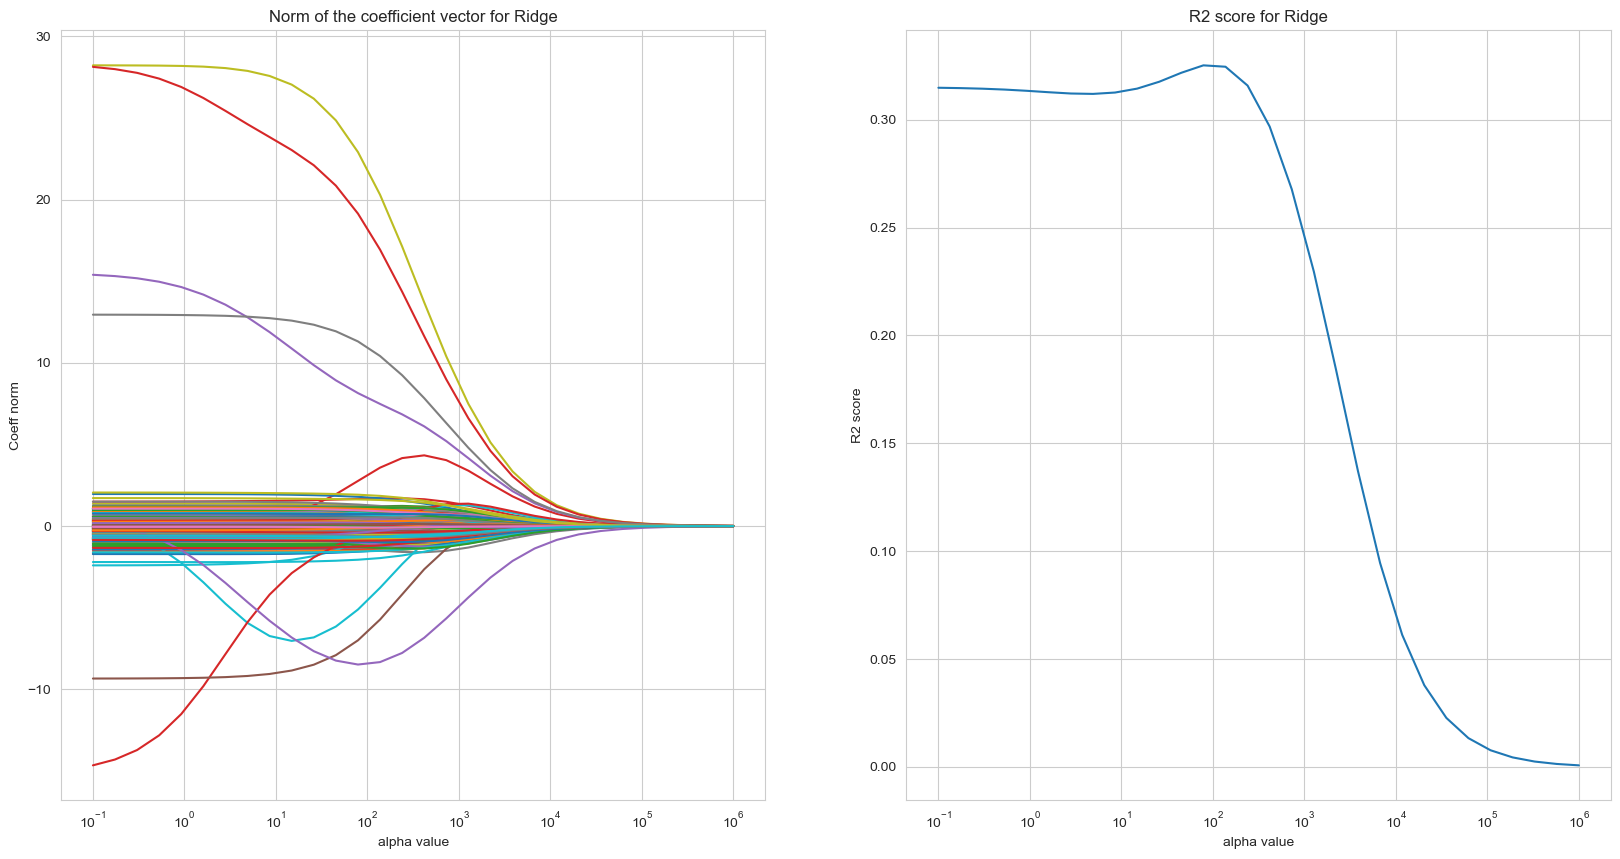

In [26]:
alpha_array = np.logspace(-1, 6, 30) # different penalty parameters
coeff_list = []
coeff_norm_list = []
R2_score_list = []
for alpha in alpha_array:
    model_ridge_ex = Ridge(alpha)
    model_ridge_ex.fit(X_train_std,y_train)
    ridge_param_ex = model_ridge_ex.get_params()
    coeffs = model_ridge_ex.coef_
    coeff_list.append(coeffs)
    coeff_norm_list.append(np.linalg.norm(coeffs))
    y_hat = model_ridge_ex.predict(X_test_std)
    R2_score_list.append(1 - np.sum((y_test-y_hat)**2)/np.sum((y_test-y_test.mean())**2))
    # R2_score_list.append(r2_score(y_test, y_hat))
    
#     display(np.linalg.norm(coeffs))
fig = plt.figure(figsize=(20,10))

fig.add_subplot(1,2,1)
plt.title("Norm of the coefficient vector for Ridge")
plt.xlabel("alpha value")
plt.ylabel("Coeff norm")
plt.plot(alpha_array, np.array(coeff_list))
plt.xscale('log')

fig.add_subplot(1,2,2)
plt.title("R2 score for Ridge")
plt.xlabel("alpha value")
plt.ylabel("R2 score")
plt.plot(alpha_array, np.array(R2_score_list))
plt.xscale('log')

plt.show()

In [27]:
def apply_model(model, alpha_list, model_name):
    coeff_list = []
    coeff_norm_list = []
    R2_score_list = []
    for alpha in alpha_array:
        model_main = model(alpha)
        model_main.fit(X_train_std,y_train)
        coeffs = model_main.coef_
        coeff_list.append(coeffs)
        coeff_norm_list.append(np.linalg.norm(coeffs))
        y_hat = model_main.predict(X_test_std)
        R2_score_list.append(r2_score(y_test, y_hat))

    #     display(np.linalg.norm(coeffs))
    fig = plt.figure(figsize=(20,10))

    fig.add_subplot(1,2,1)
    plt.title("Norm of the coefficient vector for "+model_name)
    plt.xlabel("alpha value")
    plt.ylabel("Coeff norm")
    plt.plot(alpha_array, np.array(coeff_list))
    plt.xscale('log')

    fig.add_subplot(1,2,2)
    plt.title("R2 score for "+model_name)
    plt.xlabel("alpha value")
    plt.ylabel("R2 score")
    plt.plot(alpha_array, np.array(R2_score_list))
    plt.xscale('log')

    plt.show()
    return coeff_list, R2_score_list

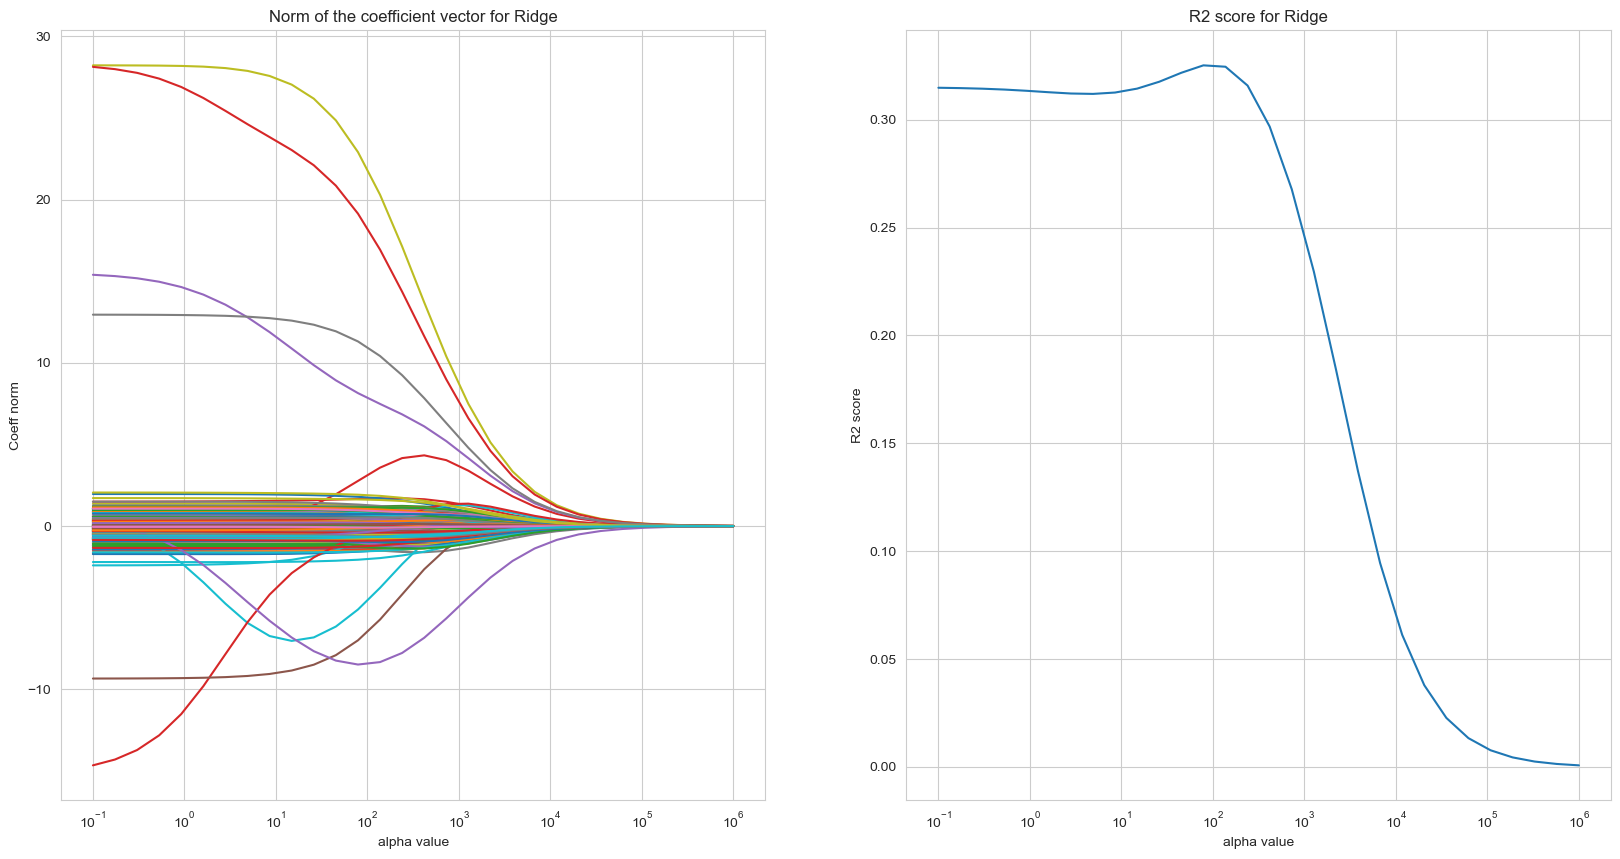

In [28]:
coeff_ridge, R2_ridge = apply_model(Ridge, np.logspace(-1, 6, 30), "Ridge")

## Question 5

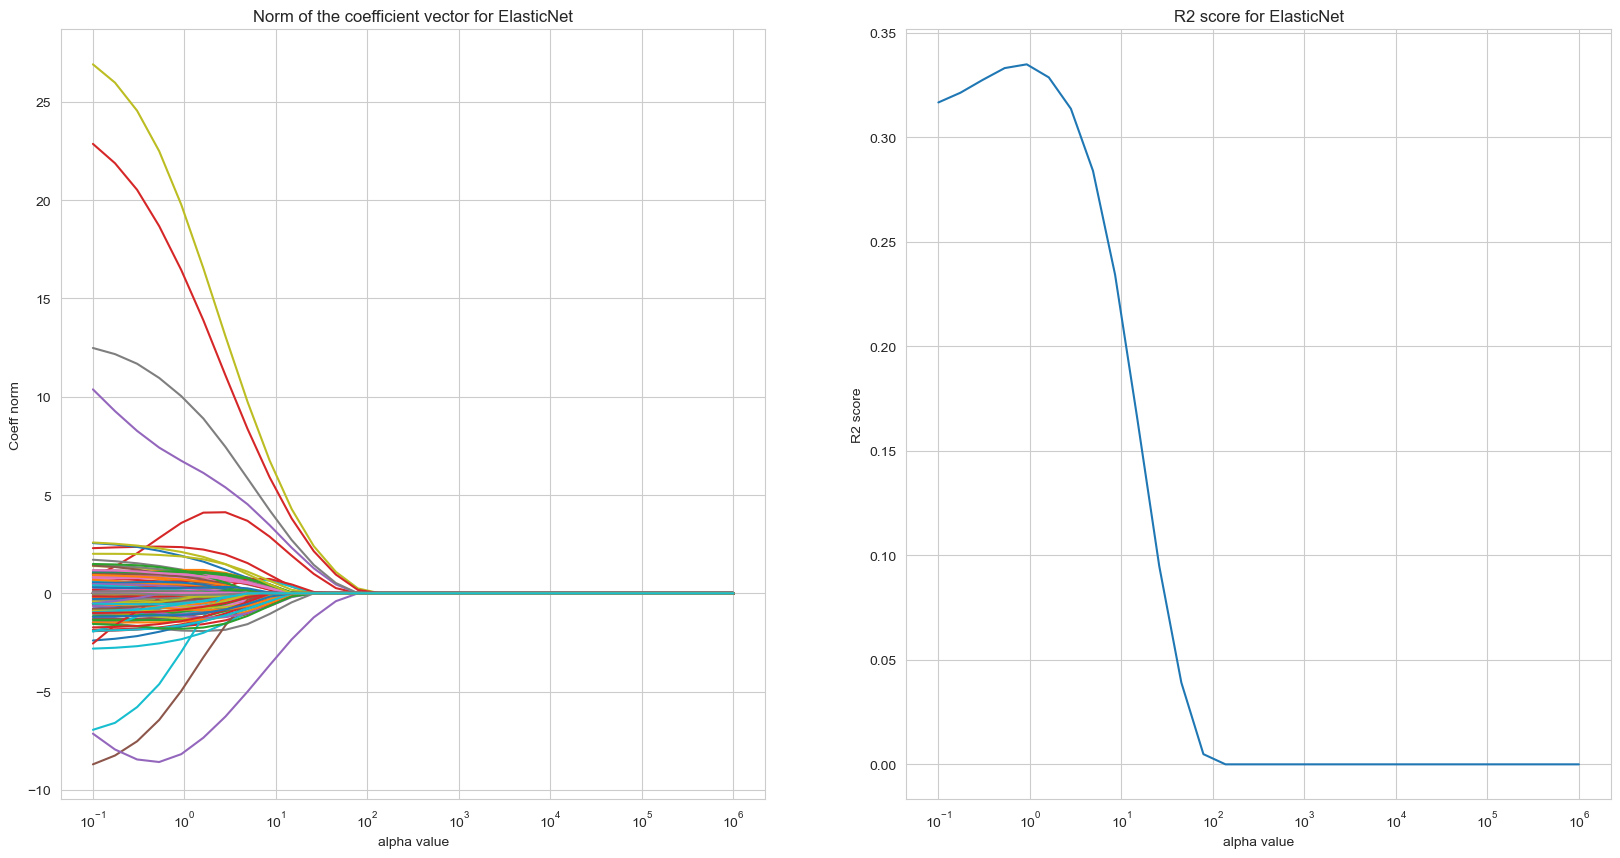

In [29]:
coeff_elastic, R2_elastic = apply_model(ElasticNet, np.logspace(-3, 2, 30),"ElasticNet")

## Question 6

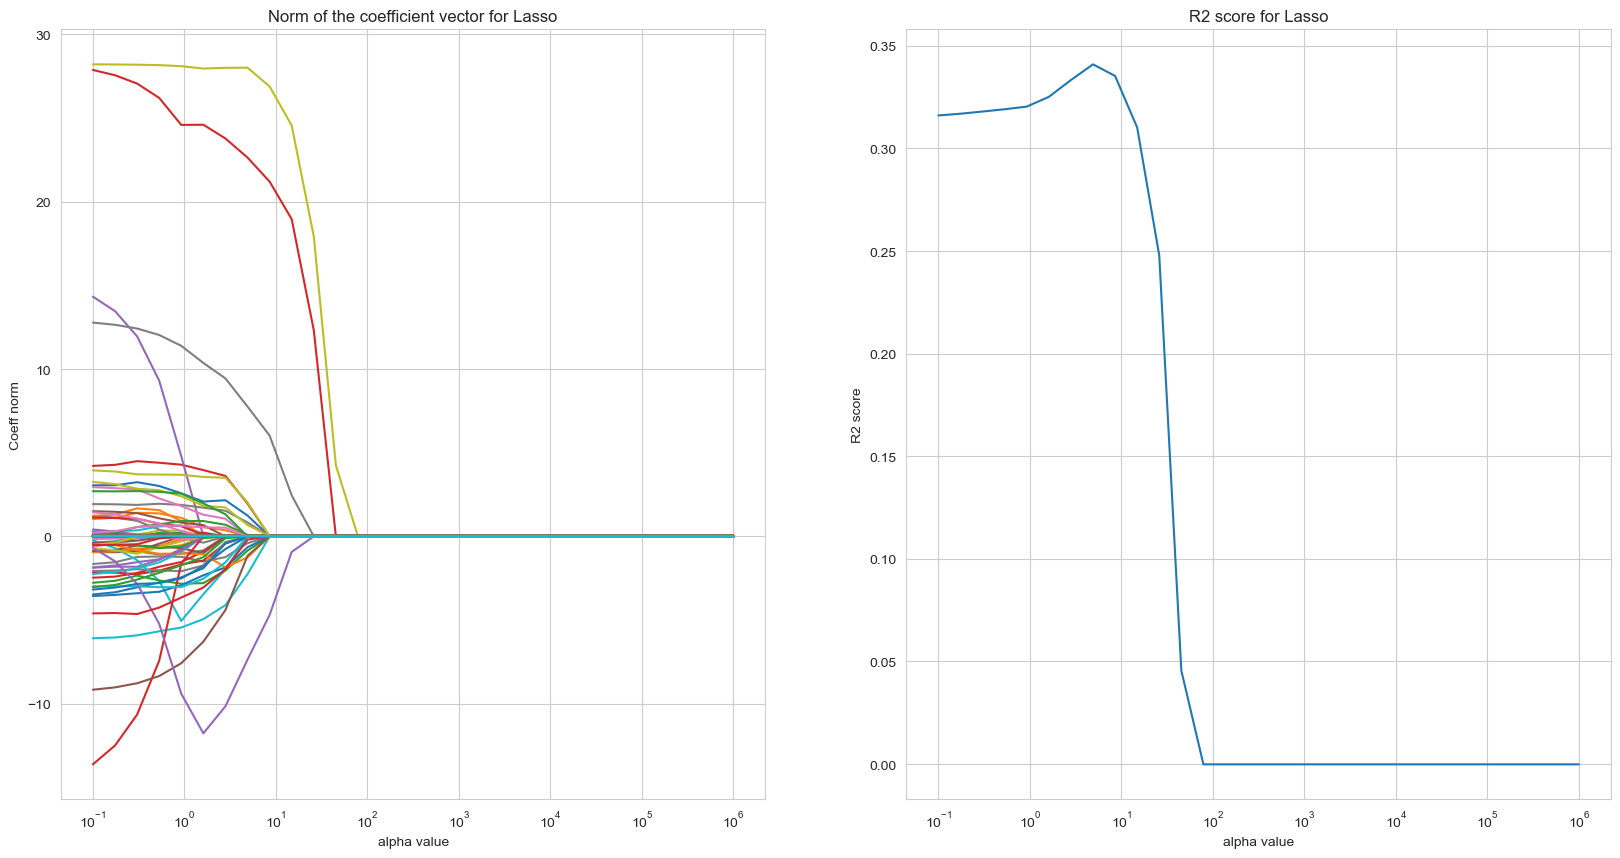

In [30]:
coeff_lasso, R2_lasso = apply_model(Lasso, np.logspace(-3, 2, 30),"Lasso")

## Question 7

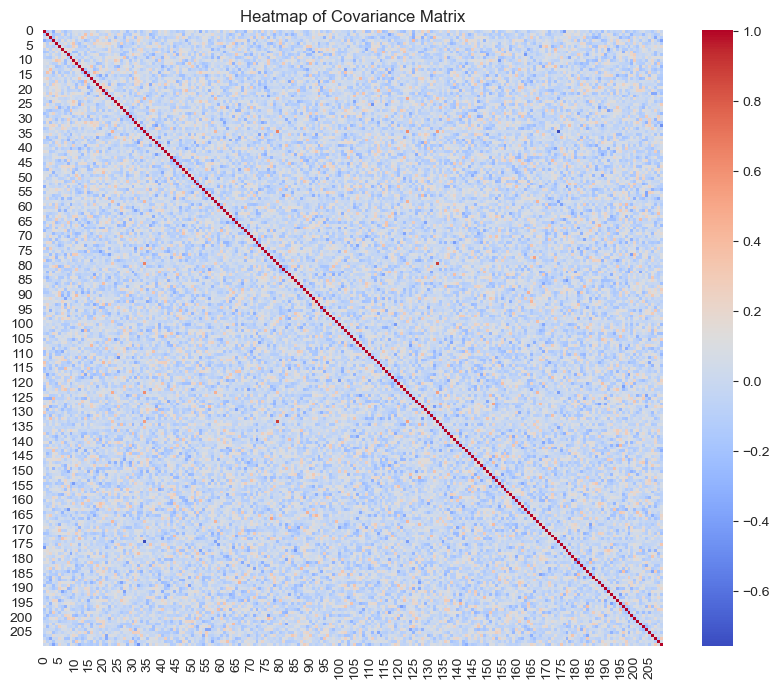

In [31]:
X = X_train_std.copy()
cov_matrix = np.cov(X.T)
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, cmap='coolwarm')
plt.title("Heatmap of Covariance Matrix")
plt.show()

In [32]:
# Compute the PCA for the data using the SVD.
U,s,Vt = np.linalg.svd(X.T @ X,full_matrices=False)
X_PCA = X @ U # X in the bases of principal components

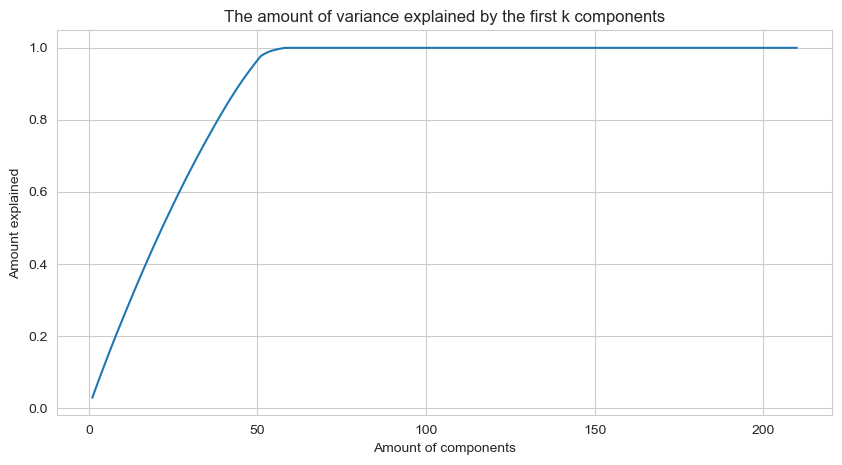

In [33]:
# Plot the amount of variance explained 
p = s.shape[0]
plt.figure(figsize=(10,5))
plt.plot([k for k in range(1, p+1)], [s[:k].sum()/s.sum() for k in range(1,p+1)])
plt.xlabel("Amount of components")
plt.ylabel("Amount explained")
plt.title("The amount of variance explained by the first k components")
plt.show()

In [35]:
for k in range(1,50):
    if s[:k].sum()/s.sum() > 0.9:
        print(f"We need {k+1} components to explain more than 90% of the variance")
        break

We need 46 components to explain more than 90% of the variance


Here we plot the data that is projected onto the first two components in the bases of the first two components.

We can see that the data points are more or less evenly distributed in the new projection subspace of the SVD decomposition, that is because SVD decomposition tries to find the components that gives the biggest variations in data.

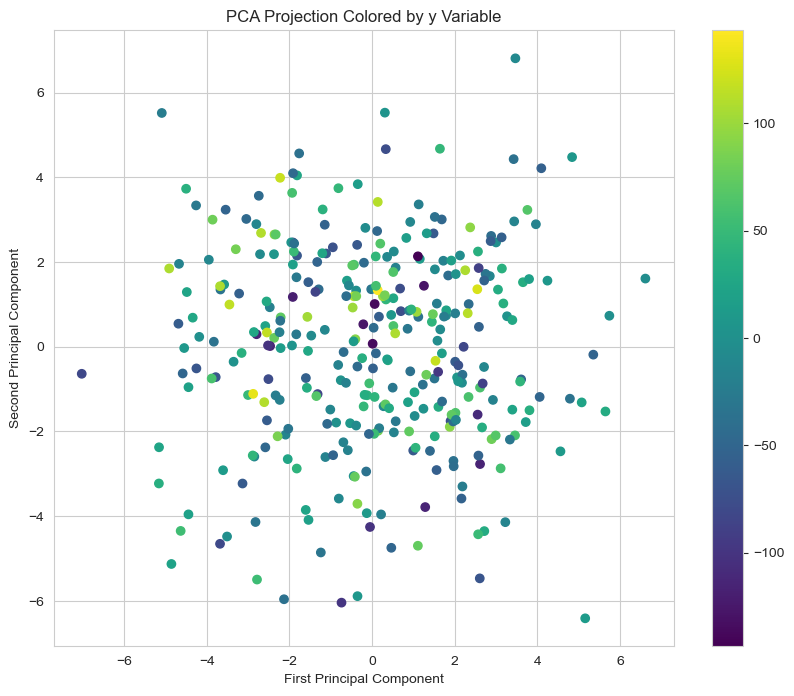

In [51]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Projection Colored by y Variable')

scale_factor = 50

# principal_components = U[:2, :]
# Plot the principal axes
# for i, component in enumerate(principal_components):
#     scaled_component = component * scale_factor / np.linalg.norm(component)
#     plt.arrow(0, 0, scaled_component[0], scaled_component[1],head_width=0.2, head_length=0.5, edgecolor = 'b',lw=1,label=f"principal dirctions {i+1}")
# plt.legend()
plt.show()

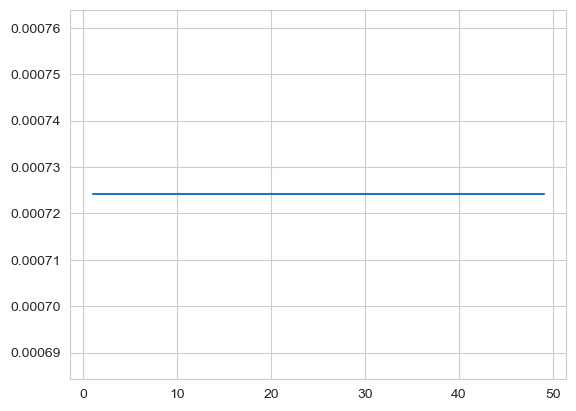

In [53]:
# run OLS on the projected data
R2_list_PCA = []
X_test_PCA = X_test_std @ U # test set that is projected to the PCA space
for k in range(1, 50):
    X = X_PCA[:, :k] # the X_PCA that we defined for the SVD decomposition
    theta_vector = np.linalg.pinv(X.T @ X) @ X.T @ y_train
    y_hat_PCA = X_test_PCA[:,:k] @ theta_vector
    R2_list_PCA.append(r2_score(y_test, y_hat))
plt.plot([k for k in range(1,50)],R2_list_PCA)

In [58]:
k_best = np.array([k for k in range(1,50)])[np.array(R2_list_PCA).argmax()]
k_best

1

Therefore the k that returns the best result is 1
## Question 8

In [61]:
from sklearn.metrics import mean_squared_error

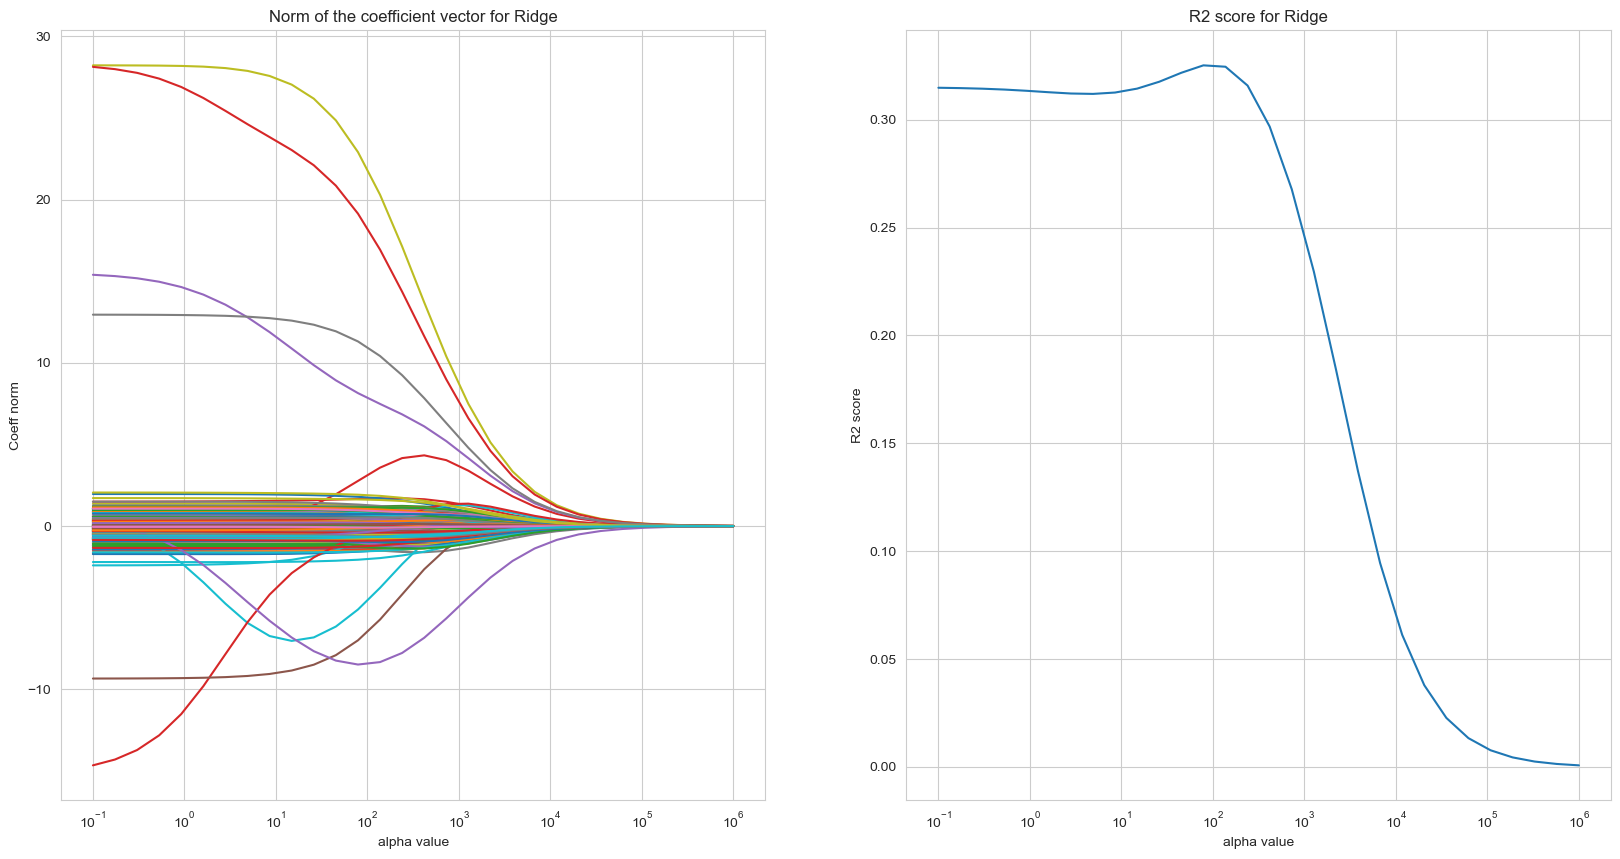

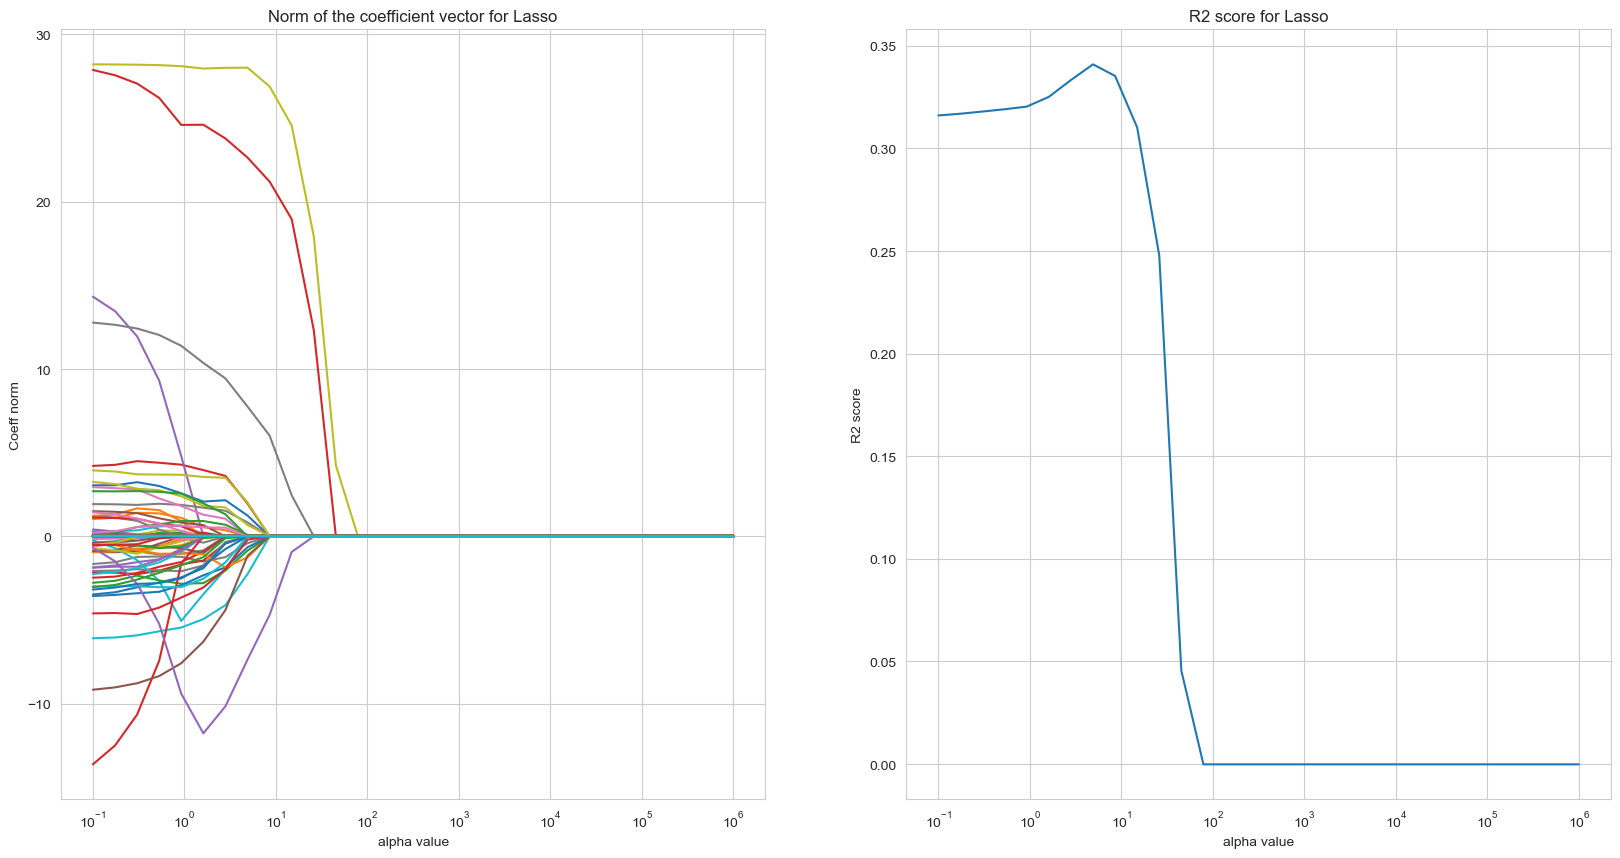

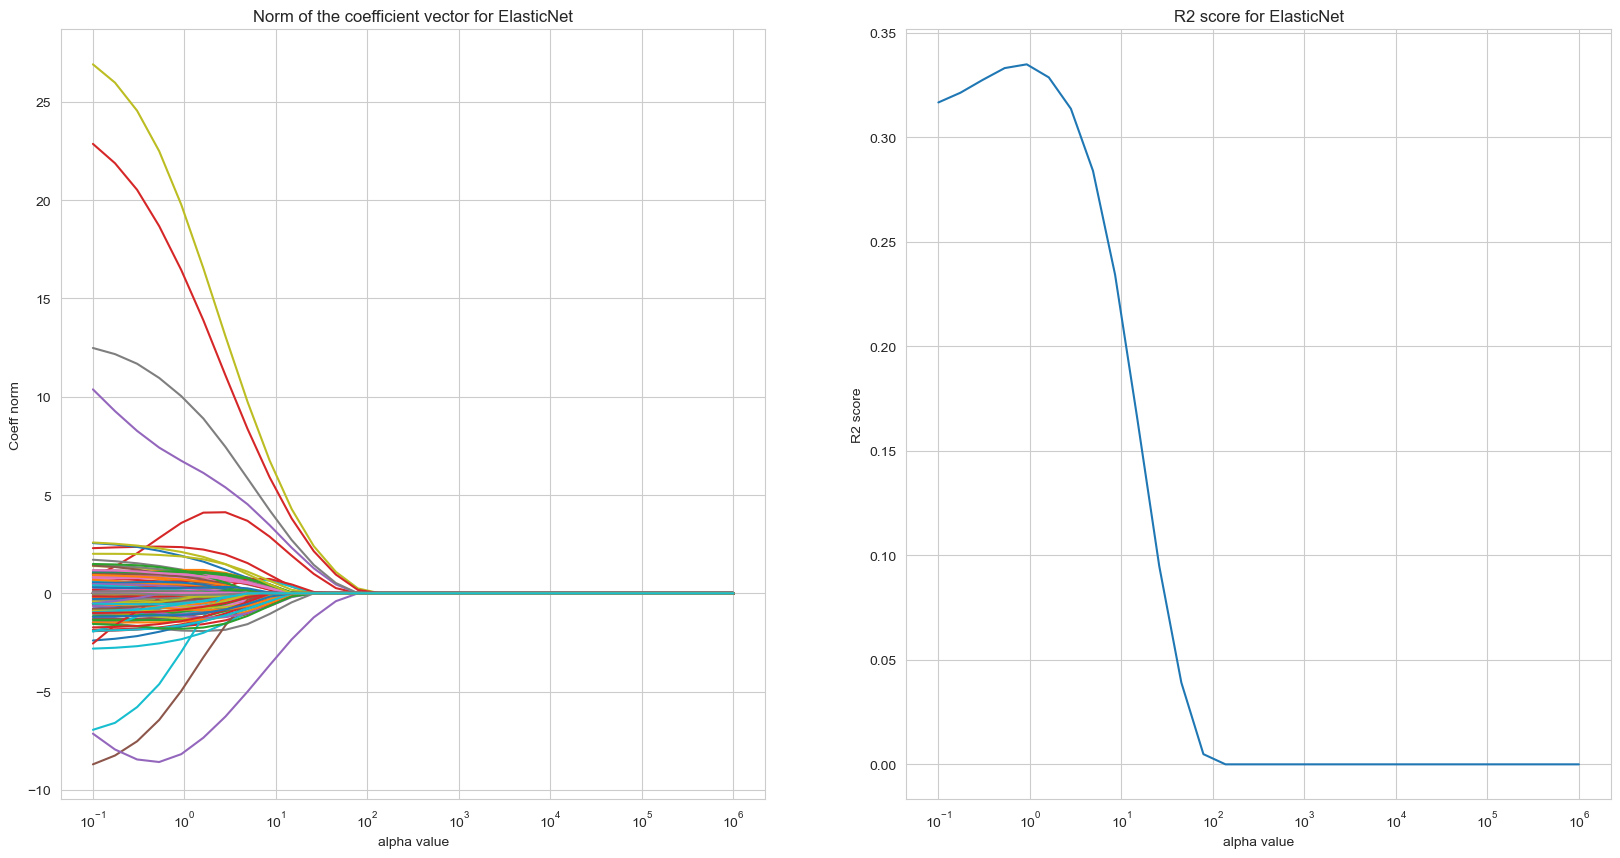

In [66]:
## regular OLS
y_train_hat_OLS1 = model2.predict(X_train_std)
y_test_hat_OLS1 = model2.predict(X_test_std)

OLS1_train_err = mean_squared_error(y_train, y_train_hat_OLS1)
OLS1_test_err = mean_squared_error(y_test, y_test_hat_OLS1)

## forward variable selection
X_train_std_S = X_train_std[:, [k for k in S]]
X_test_std_S = X_test_std[:, [k for k in S]]
model_selection = LinearRegression()
model_selection.fit(X_train_std_S, y_train)
y_train_hat_forward = model_selection.predict(X_train_std_S)
y_test_hat_forward = model_selection.predict(X_test_std_S)

forward_train_err = mean_squared_error(y_train, y_train_hat_forward)
forward_test_err = mean_squared_error(y_test, y_test_hat_forward)

## Ridge, we choose the best penalty parameter
coeff_ridge, R2_ridge = apply_model(Ridge, np.logspace(-1, 6, 30), "Ridge")
best_ridge_coeff = coeff_ridge[np.array(R2_ridge).argmax()]
y_train_hat_ridge = X_train_std @ best_ridge_coeff.reshape((best_ridge_coeff.shape[0],1))
y_test_hat_ridge = X_test_std @ best_ridge_coeff.reshape((best_ridge_coeff.shape[0],1))

ridge_train_err = mean_squared_error(y_train, y_train_hat_ridge)
ridge_test_err = mean_squared_error(y_test, y_test_hat_ridge)

## Lasso, we choose the best penalty parameter
coeff_lasso, R2_lasso = apply_model(Lasso, np.logspace(-3, 2, 30), "Lasso")
best_lasso_coeff = coeff_lasso[np.array(R2_lasso).argmax()]
y_train_hat_lasso = X_train_std @ best_lasso_coeff.reshape((best_lasso_coeff.shape[0],1))
y_test_hat_lasso = X_test_std @ best_lasso_coeff.reshape((best_lasso_coeff.shape[0],1))

lasso_train_err = mean_squared_error(y_train, y_train_hat_lasso)
lasso_test_err = mean_squared_error(y_test, y_test_hat_lasso)

## elastic net, we choose the best penalty parameter
coeff_enet, R2_enet = apply_model(ElasticNet, np.logspace(-3, 2, 30), "ElasticNet")
best_enet_coeff = coeff_enet[np.array(R2_enet).argmax()]
y_train_hat_enet = X_train_std @ best_enet_coeff.reshape((best_enet_coeff.shape[0],1))
y_test_hat_enet = X_test_std @ best_enet_coeff.reshape((best_enet_coeff.shape[0],1))

enet_train_err = mean_squared_error(y_train, y_train_hat_enet)
enet_test_err = mean_squared_error(y_test, y_test_hat_enet)

## PCA
X_train_PCA_best = X_PCA[:, :1]
X_test_PCA_best = X_test_PCA [:, :1]
theta_PCA = np.linalg.pinv(X_train_PCA_best.T @ X_train_PCA_best) @ X_train_PCA_best.T @ y_train
y_train_hat_PCA = X_train_PCA_best @ theta_PCA.reshape((theta_PCA.shape[0],1))
y_test_hat_PCA = X_test_PCA_best @ theta_PCA.reshape((theta_PCA.shape[0],1))

PCA_train_err = mean_squared_error(y_train, y_train_hat_PCA)
PCA_test_err = mean_squared_error(y_test, y_test_hat_PCA)

In [67]:
dict_result = {
    "model":["OLS regular", "Variable Selection", "Ridge","Lasso","ElasticNet","PCA"],
    "train_error":[OLS1_train_err, forward_train_err, ridge_train_err, lasso_train_err, enet_train_err, PCA_train_err],
    "test_error":[OLS1_test_err, forward_test_err, ridge_test_err, lasso_test_err, enet_test_err, PCA_test_err]
}
df_result = pd.DataFrame(dict_result)
df_result

,model,train_error,test_error
0,OLS regular,2627.305848,3597.362158
1,Variable Selection,3137.001608,4164.477182
2,Ridge,25532.723868,25088.771399
3,Lasso,25892.906734,25302.608143
4,ElasticNet,25663.240958,25253.599576
5,PCA,28404.947767,27720.231028


<Figure size 1000x800 with 0 Axes>

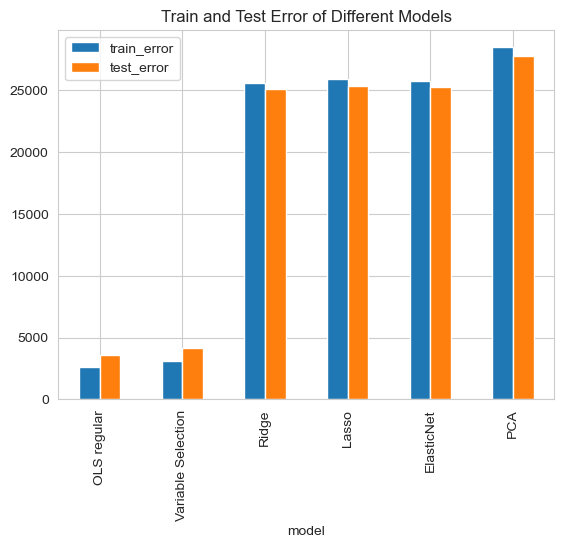

In [69]:
plt.figure(figsize=(10,8))
df_result.plot.bar("model", ["train_error","test_error"])
plt.title("Train and Test Error of Different Models")
plt.show()